----
# CNN with Augmented Data
----

### Summary:
Evaluating the performance of the CNN model when trained on augmented data. By augmenting MNIST sign language dataset, more noise is added to the images which simulate real-world scenarios. Training the model on augmented data allows the model to generalise better and therefore become more robust.

### Data Overview:
- **Dataset**: MNIST Sign Language Dataset
- **Number of Samples**: Approximately 1400 images per character
- **Image Dimensions**: Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:
- **Data Augmentation**:
    - Load augmented data.

- **Training my CNN**:
   - Compile the model.
   - Train the model on augmented data

- **Model Evaluation**:
   - Assess the accuracy of the model on the validation dataset.
   - Analyse the model's performance using a confusion matrix and visualise misclassifications.

### Data Augmentation Reminder:

- rescale=1./255             
    > Normalisation of the input data is best when working with neural networks
- rotation_range=20          
    > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      
    > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     
    > To ensure model is able to deal with off-centered images
- shear_range=0.2            
    > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             
    > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=True       
    > To mimic opposite hand, if original image is left hand we can flip the image to show right hand

## Set Up
-----

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import random

import joblib
import math


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Data Loading
---

In [3]:
X  = joblib.load( '../../data/my_data/X.pkl' )
y = joblib.load( '../../data/my_data/y.pkl' )

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28,28,-1)
X_val = X_val.reshape(X_val.shape[0], 28,28,-1)

In [6]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

### Augmented data loading

In [7]:
# Note augmentation includes scaling of the data
train_datagen = joblib.load('../../model/my_files/train_datagen.pkl') 
val_datagen = joblib.load('../../model/my_files/val_datagen.pkl') 

In [8]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

NOTE: Training data is the only one where augmentation techniques are applied, the validation data is only rescaled in the augmentation!

## Training the model
---

In [9]:
CNN_model = load_model('../../model/my_models/CNN_model.h5')

In [10]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [11]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [12]:
history = CNN_model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=10,
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        callbacks=[early_stop]
            )

Epoch 1/10


2024-07-06 17:17:34.119322: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


866/866 [==============================] - 11s 12ms/step - loss: 1.6102 - accuracy: 0.5127 - val_loss: 1.4277 - val_accuracy: 0.5946
Epoch 2/10
866/866 [==============================] - 10s 11ms/step - loss: 0.8828 - accuracy: 0.7027 - val_loss: 0.3992 - val_accuracy: 0.8511
Epoch 3/10
866/866 [==============================] - 10s 11ms/step - loss: 0.6718 - accuracy: 0.7697 - val_loss: 0.7871 - val_accuracy: 0.7521
Epoch 4/10
866/866 [==============================] - 10s 11ms/step - loss: 0.5657 - accuracy: 0.8073 - val_loss: 0.6422 - val_accuracy: 0.8168
Epoch 4: early stopping


### Saving the model

In [25]:
CNN_model.save('../../model/my_models/CNN_augmented_model.h5')

### Assessing training and validation scores

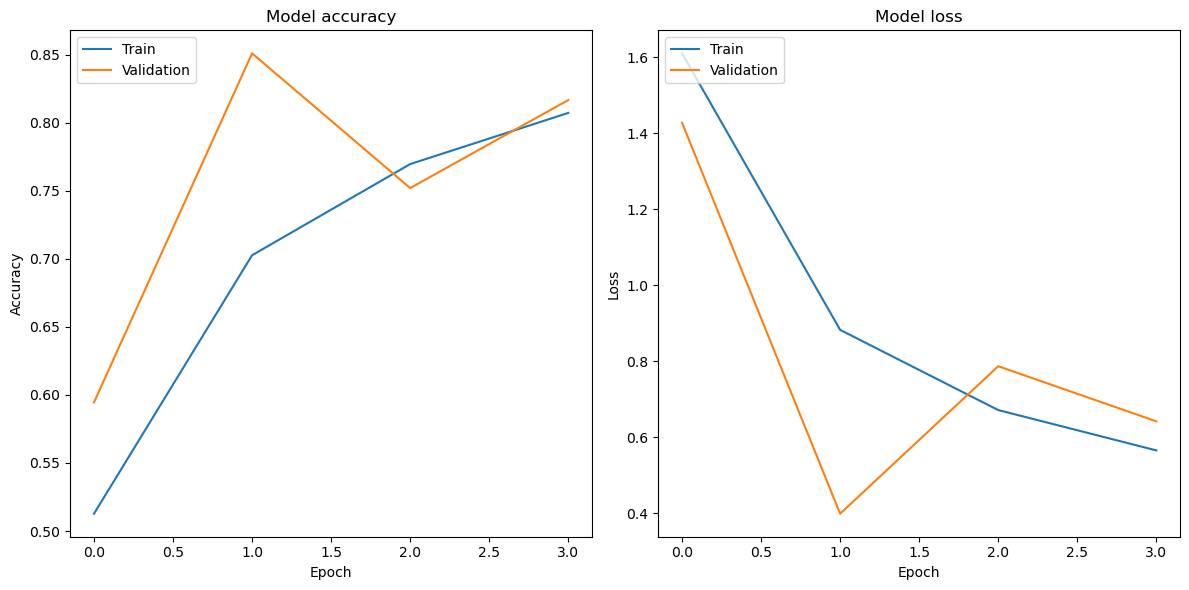

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Comment:**

The difference in accuracy and loss we are seeing between the validation and training data for augmented data is substantial.

- Augmentation methods were only applied to the training data. The variations applied to images can make the accuracy of the training data lower as it becomes more challenging to learn as images are less consistent. The purpose of applying augmentation is to make the model more robust so it can generalise better to unseen data.

- The validation dataset is non-augmented images, the purpose of the validation dataset is test the model is able to generalise well after augmentation techniques were applied during training. Overall, there is a positive result which means the model is still able to learn features from the augmented data which can be applied to a dataset where there is no augmentation.



In [18]:
train_loss, train_acc = CNN_model.evaluate(train_generator)
print(f'CNN with augmentation train score: {round(train_acc*100,4)}')

866/866 [==============================] - 3s 4ms/step - loss: 1.3315 - accuracy: 0.6076
CNN with augmentation train score: 60.7632


In [20]:
val_loss, val_acc = CNN_model.evaluate(val_generator)
print(f'CNN with augmentation validation score: {round(val_acc*100,4)}')

217/217 [==============================] - 3s 11ms/step - loss: 0.6422 - accuracy: 0.8168
CNN with augmentation validation score: 81.6777


**Comment:**

See such a differnce here between the train and the validation results as the validation images were only scaled and so without augmentation the model we built in the previous notebook already has a high performance so the performance on the validation set remains high. 

## Model Evaluation
-----

In [ ]:
CNN_aug_model = load_model('../../model/my_models/CNN_augmented_model.h5')

#### Confusion Matrix

217/217 [==============================] - 1s 5ms/step


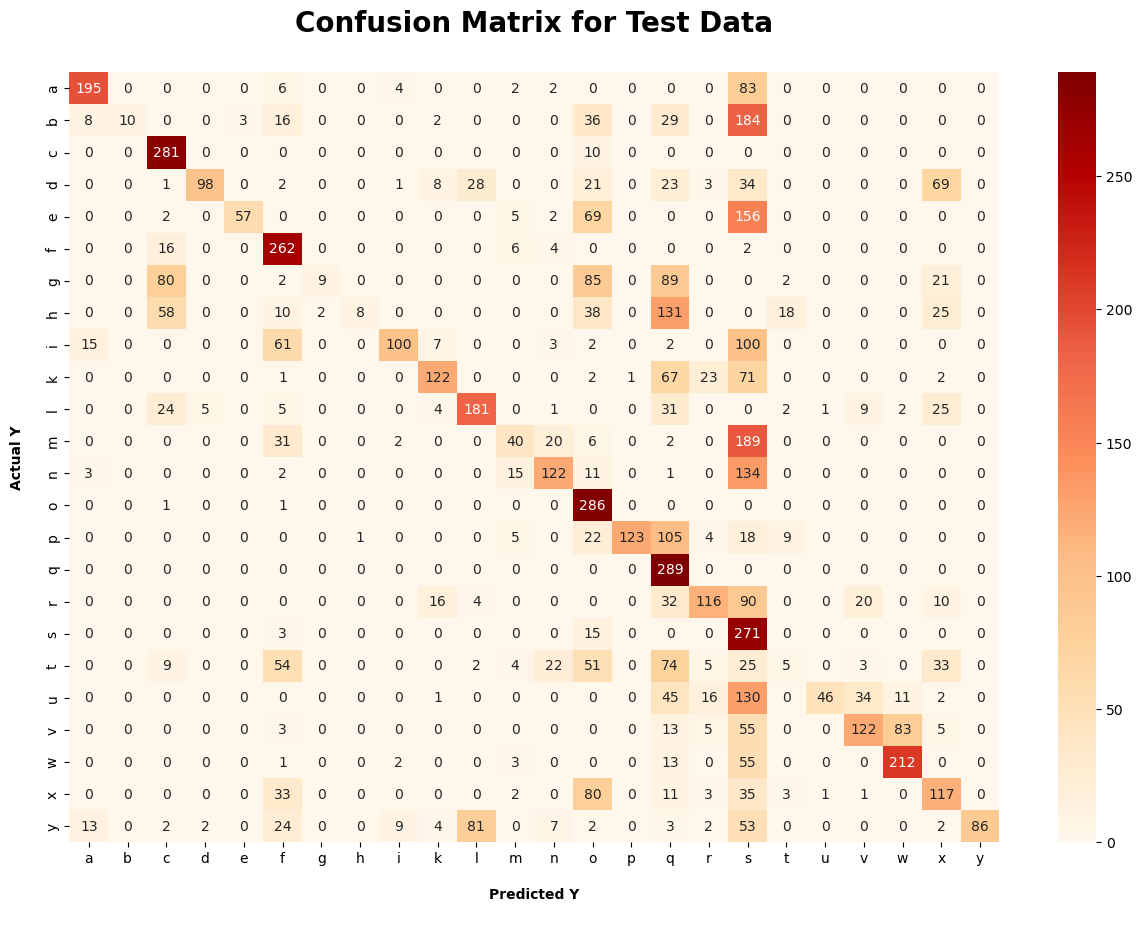

In [26]:
from sklearn.metrics import confusion_matrix

# Calculate the predicted labels for each test image.
soft_pred = CNN_model.predict(X_val)
pred_y = np.argmax(soft_pred, axis=1)

# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat,
            annot=True,
            fmt = 'd',
            cmap="OrRd",
           )
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Comment:**

As expected the number of misclassifications are a lot higher when data is augmented as the model finds it more challenging to learn distinctive features for each class.


### Visualising misclassifications on validation set

In [64]:
incorrect_photos = (y_val != pred_y)
num_photos = incorrect_photos.sum()

In [65]:
# too many photos to plot 
num_photos

3768

In [66]:
# genreate list of incorrect photos and select 12 at random to visualise
to_plot = np.where(incorrect_photos)[0]
rand_photos = random.sample(list(to_plot),15)

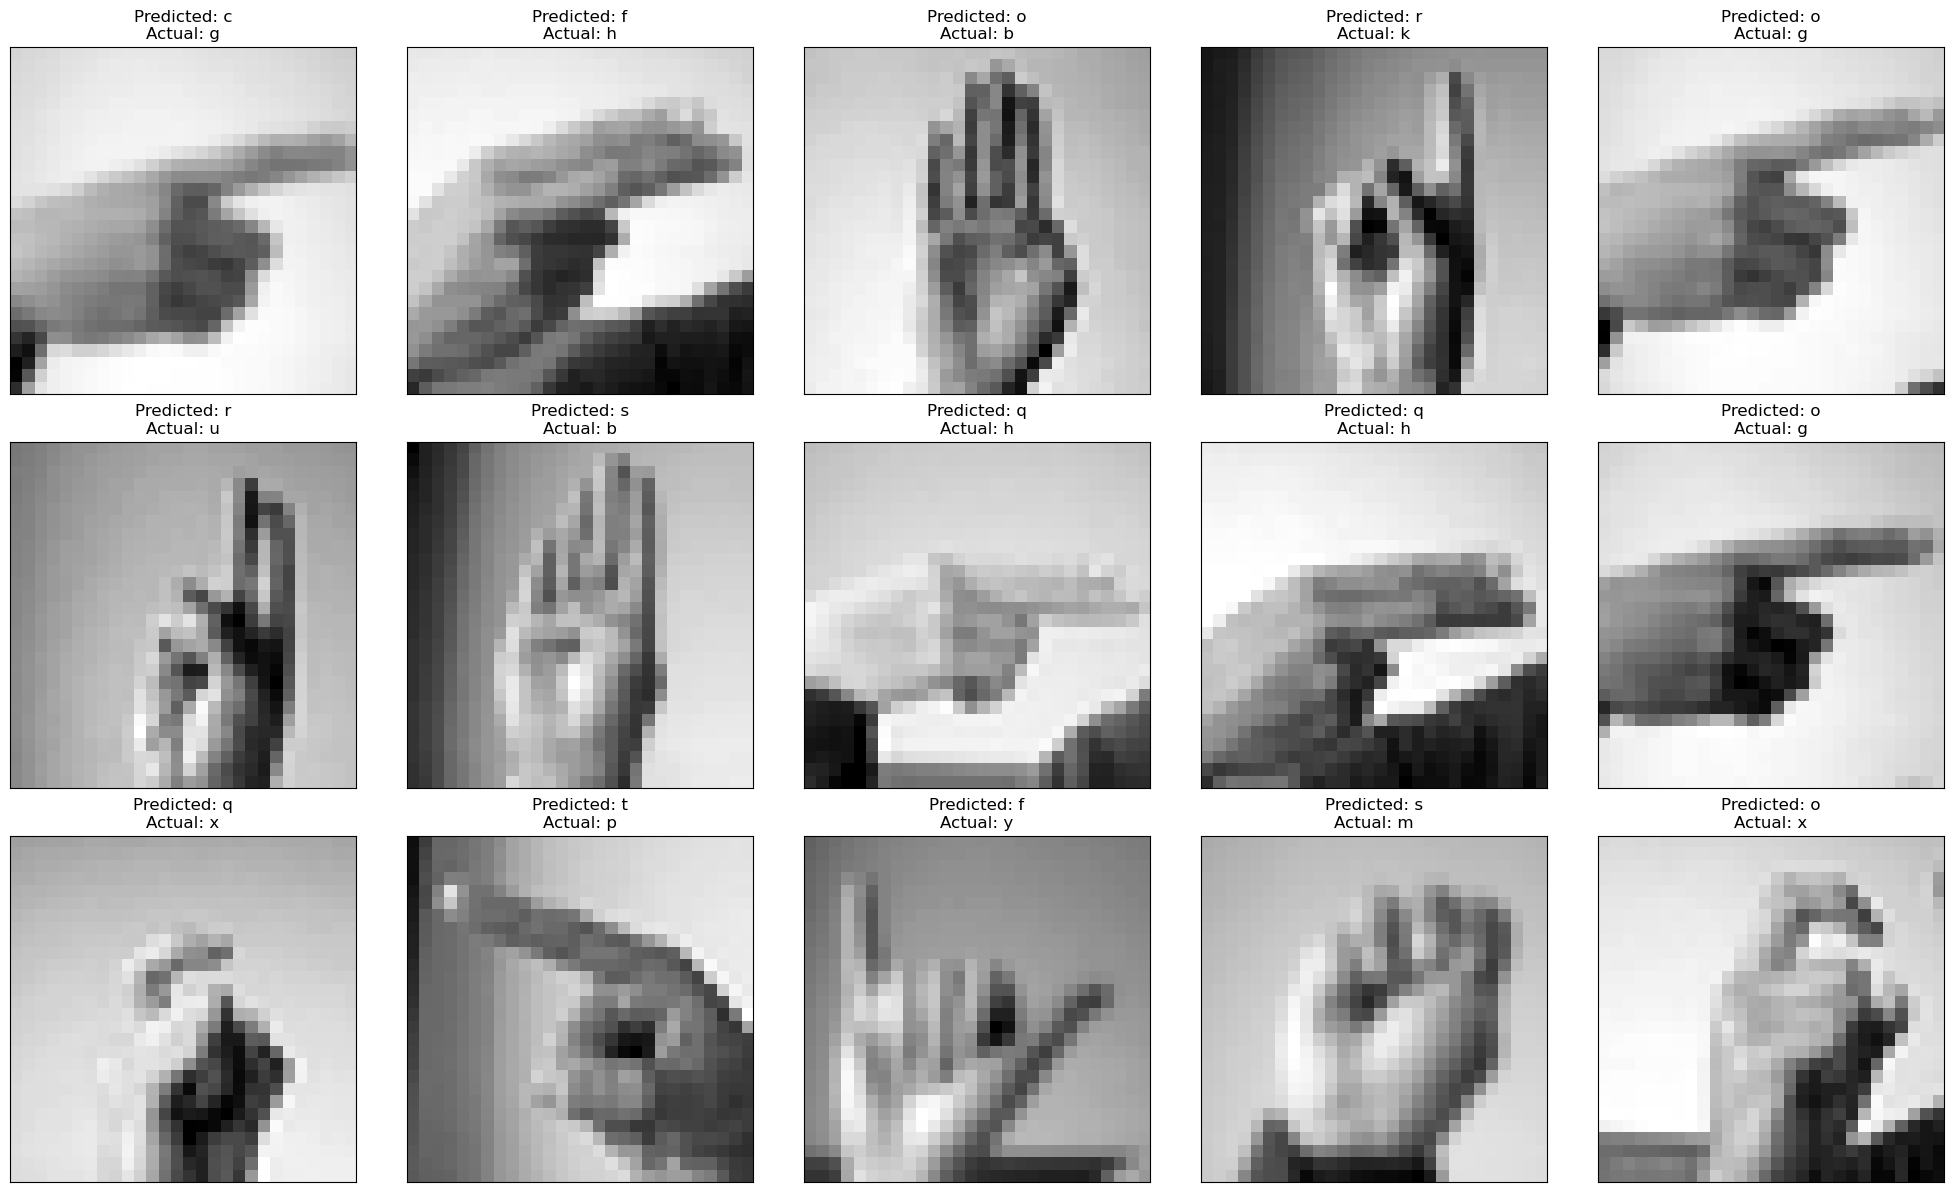

In [67]:
rows = math.ceil(len(rand_photos) / 5)

fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))

for i, ax in enumerate(axes.flatten()):
    if i < num_photos:
        ax.imshow(X_val[rand_photos][i], cmap='gray')

        # Get predicted label
        p = pred_y[rand_photos][i]
        prediction = alphabet[p]

        # Get actual label
        a = y_val[rand_photos][i]
        actual = alphabet[a.astype(np.int32)]

        # Set the title of the subplot
        ax.set_title(f"Predicted: {prediction}\nActual: {actual}")

        # Hide the x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        fig.delaxes(ax)  # Delete unused subplots

plt.tight_layout()
plt.show()

**Comment:**

Interesting to see what letter the model thought the different images in the validation set were after training on the augmented data.

We can use this plot later if we want to fine-tune the data augmentaion parameters especially if we assess the most common misclassifications in the dataset.

### Testing an Unseen Input Image

In [69]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

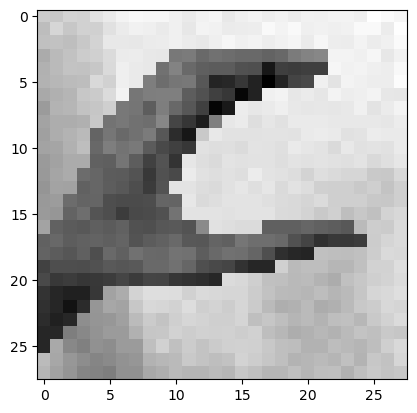

In [70]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [71]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [72]:
# Reshaping to have dimesntions (1,28,28,1) -> to match X_train/X_test dimensions
# 1 as only single image is uploaded
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [74]:
soft_pred = CNN_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 15ms/step


In [76]:
print(f'Prediction using CNN trained with augmented data: \n{alphabet[pred_y[0]].upper()}')

Prediction using CNN trained with augmented data: 
C


## Conclusion
----

|                  | CNN        | CNN with augmentation |
|------------------|------------|-----------------------|
| Train Score      | 99.89      | 60.76                 |
| Validation Score | 99.81      | 81.67                 |

Peformance of CNN with augmentation shows a significantly lower training accuracy compared to the base CNN. This difference is due to introduction of augmentation into the dataset and shows the difficulity the model had in learning when noise is present. Despite a lower training score, the augmented CNN model reaches 82% accuracy on the validation data. While this is lower than the base CNN, the improvement seen comapred to the training score shows how effective data augmentation can be in terms of the model generalising to unseen data.

To conclude, the results in this notebook highlight the importance of introducing noise into a dataset in order to imporve a model's ability to generalise. Perhaps the augmentation I applied was too harsh and this will be something to circle back to and play around with at a later date.